In [1]:
import os
import shutil

import pandas as pd
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import mlflow
from mlflow.models.signature import infer_signature
from mlflow.data.pandas_dataset import PandasDataset
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from dotenv import load_dotenv
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import torchxrayvision as xrv
import torchvision.transforms as transforms
import numpy as np
import torch

from functions.image.img_analysis import get_images_info
from functions.image.img_treatment import prepare_data
from functions.visualizations.img_show import show_images
from functions.visualizations.show_predictions import show_predictions
from functions.data import get_train_test
import functions.models as custom_models
from functions.mlflow import get_run_name
from settings import params, model_name, folders, added_layers, experiment_name


# Sets the number of threads
tf.config.threading.set_inter_op_parallelism_threads(2)
tf.config.threading.set_intra_op_parallelism_threads(12)
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"


# Loads the MLFlow credentials
load_dotenv()

True

In [ ]:
# Download latest version of dataset and store it locally
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

target_dir = "data"
os.makedirs(target_dir, exist_ok=True)
shutil.move(path, target_dir)
removable_folder_paths = ("data/chest_xray/", "data/2/chest_xray/chest_xray", "data/2/chest_xray/__MACOSX")
for folder_path in removable_folder_paths:
    if os.path.exists(folder_path) and os.path.isdir(folder_path):
        shutil.rmtree(folder_path)

In [ ]:
# Analyser les images
df_train_images = get_images_info(folders["train"]["input"])
df_train_valid = df_train_images[df_train_images["error"] == False]

# Identifier les images extrêmes
extremes = pd.concat([
    df_train_valid.loc[df_train_valid["width"].idxmax()],
    df_train_valid.loc[df_train_valid["width"].idxmin()],
    df_train_valid.loc[df_train_valid["height"].idxmax()],
    df_train_valid.loc[df_train_valid["height"].idxmin()],
    df_train_valid.loc[df_train_valid["aspect_ratio"].idxmax()],
    df_train_valid.loc[df_train_valid["aspect_ratio"].idxmin()],
], axis=1).T.drop_duplicates()

# Aperçu
print(df_train_images.head())
# Statistiques
print(df_train_images.describe())
# Affichage en tableau
print("\nImages aux valeurs extrêmes :")
print(extremes.sort_values(by=["width", "height"], ascending=[False, False]))

# Effectif de chaque catégorie d'entrainement: le dataset est déséquilibré
split_path = "data/2/chest_xray/train"
for category in ["NORMAL", "PNEUMONIA"]:
    category_path = split_path + '/' + category
    count = len([
            f for f in os.listdir(category_path)
        ])
    print(f"{category}: {count} images")

# Affichage des images extrêmes
show_images(extremes.reset_index(drop=True), folder_path=folders["train"]["input"])

In [ ]:
# Transformation des images
for folder in folders:
    prepare_data(folders[folder]["input"], folders[folder]["output"])

In [2]:
# Préparation des données de travail
X_train, y_train = get_train_test(folders["train"]["output"])
X_test, y_test = get_train_test(folders["test"]["output"])
X_val, y_val = get_train_test(folders["val"]["output"])

# Rééquilibrage du dataset
class_weight_dict = {0: 1.0, 1: 1.0}
if params["equilibrate"]:
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weight_dict = dict(enumerate(class_weights))

In [ ]:
# Echantillonnage pour vérification
# Sélectionner les indices des labels
indices_label_0 = [i for i, y in enumerate(y_train) if y == 0][:5]
indices_label_1 = [i for i, y in enumerate(y_train) if y == 1][:5]

# Fusionner les indices sélectionnés
selected_indices = indices_label_0 + indices_label_1

# Affichage
plt.figure(figsize=(15, 3))
for idx, i in enumerate(selected_indices):
    plt.subplot(1, 10, idx + 1)
    plt.imshow(X_train[i], cmap="gray")
    plt.title(f"Label: {y_train[i]}", fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [3]:
# Preprocessing
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

# Normalisation : on divise les valeurs de pixels par 255 pour les ramener entre 0 et 1
X_train /= 255.0
X_test /= 255.0

#Transform y_train, y_test to the shape expected by the model
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)

if params["data_augmentation"]:
    datagen = ImageDataGenerator(
        rotation_range=10,
        horizontal_flip=True,
        zoom_range=0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
    )

    datagen.fit(X_train)
    
print(y_train.shape)
# On n'aplatit pas maintenant car les convolution ont besoin de matrices

(5216, 2)


In [4]:
# Création du modèle
model = custom_models.initialize_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 2048)           │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,696,066 (90.39 MB)

 Trainable params: 131,266 (512.76 KB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [5]:
# Entrainement du modèle
if params["data_augmentation"]:
    model_info = model.fit(
        datagen.flow(X_train, y_train, batch_size=params["batch_size"]),
        epochs=params["epochs"],
        validation_data=(X_test, y_test),
        class_weight=class_weight_dict
    )
else:
    model_info = model.fit(
        X_train, y_train,
        epochs=params["epochs"],
        batch_size=params["batch_size"],
        validation_data=(X_test, y_test),
        class_weight=class_weight_dict
    )

53/53 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.8001 - auc: 0.8720 - loss: 0.4688 - mean_squared_error: 0.1458 - precision: 0.8001 - recall: 0.8001 - val_accuracy: 0.8349 - val_auc: 0.9247 - val_loss: 0.3936 - val_mean_squared_error: 0.1167 - val_precision: 0.8349 - val_recall: 0.8349


20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 559ms/step


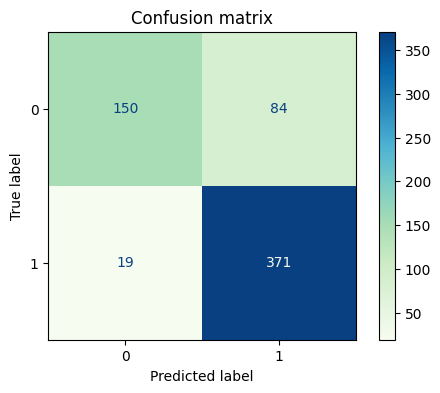

In [6]:
# Matrice de confusion
y_test_classes = np.argmax(y_test, axis=1)
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
fig, ax = plt.subplots(figsize=(6,4))
disp.plot(cmap='GnBu', ax=ax) 
plt.title("Confusion matrix")
img_path = "confusion_matrix.png"
plt.savefig(img_path)
plt.show()
plt.close()

In [ ]:
y_pred = model.predict(X_test)

y_test_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)

sns.heatmap(conf_matrix, fmt='d', annot=True)
plt.xlabel("Prédiction")
plt.ylabel("Réalité")
plt.title("Matrice de confusion")
plt.show()

In [7]:
# Log results into MLFlow
results = {}
results["loss"], results["recall"], results["accuracy"], results["precision"], results["auc"], results["mean_squared_error"] = model.evaluate(X_test, y_test)

mlflow.set_tracking_uri("http://mlflow.cpetit.fr/")
experiment = mlflow.set_experiment(experiment_name=experiment_name)
run_name = get_run_name(experiment, params["model"])

with mlflow.start_run(run_name=run_name) as run:
    run_id = run.info.run_id

    # Log dataset
    mlflow.log_param("dataset_url", "https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia")
    mlflow.set_tag("dataset", "chest-xray-pneumonia")

    # Log parameters
    mlflow.log_params(params)
    for i, added_layer in enumerate(added_layers):
         mlflow.log_params({
            f"added_layer_{i}": added_layer
        })
    # Log training metrics
    for epoch in range(len(model_info.history['loss'])):
        for metric_name, values in model_info.history.items():
            mlflow.log_metric(f"training {metric_name}", values[epoch], step=epoch)
    # Log final metrics
    mlflow.log_metrics(
        results
    )
    # Log confusion matrix
    mlflow.log_artifact(img_path, artifact_path="confusion_matrix")
    # Log model
    mlflow.tensorflow.log_model(
            model=model,
            artifact_path=model_name,
            input_example=X_test[:5],
            signature = infer_signature(X_test, model.predict(X_test))
        )

    model_uri = f"runs:/{run_id}/{model_name}"
    mlflow.register_model(model_uri=model_uri, name=model_name)

20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 501ms/step - accuracy: 0.7270 - auc: 0.8174 - loss: 0.6275 - mean_squared_error: 0.1881 - precision: 0.7270 - recall: 0.7270
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 497ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 944ms/step


Successfully registered model 'Transfer Learning - ResNet50V2'.
2025/05/26 15:44:56 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Transfer Learning - ResNet50V2, version 1
Created version '1' of model 'Transfer Learning - ResNet50V2'.


🏃 View run Transfer Learning - ResNet50V2 #1 at: http://mlflow.cpetit.fr/#/experiments/1/runs/42b9b1acf8204008896e95074cef0996
🧪 View experiment at: http://mlflow.cpetit.fr/#/experiments/1


In [ ]:
# Load a model
model_name = input("Enter model name")
model_version = int(input("Enter model version"))
alias = "challenger"

model_uri = f"models:/{model_name}/{model_version}"

loaded_model = mlflow.tensorflow.load_model(model_uri)

y_pred = loaded_model.predict(X_val)
show_predictions(X_val, y_pred, y_true=y_val, class_names=["normal", "malade"], n_images=10)

In [ ]:
# Modele plug and play
model = xrv.models.DenseNet(weights="densenet121-res224-all")
model.eval()  # mode évaluation (pas d'entraînement)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.481], std=[0.226])  # mean/std de torchxrayvision pour chest X-rays
])

def preprocess_batch(X_np):
    # X_np : numpy array shape (N, 224, 224, 1), dtype uint8 ou float

    # 1) Convertir en float32
    X_np = X_np.astype('float32')

    # 2) Normaliser : pixel/255 -> [0,1]
    X_np /= 255.0

    # 3) Normaliser avec mean/std
    X_np = (X_np - mean) / std

    # 4) Convertir en torch tensor et permuter les dimensions pour (N, C, H, W)
    X_tensor = torch.from_numpy(X_np).permute(0, 3, 1, 2)  # (N,1,224,224)

    return X_tensor

X_test_tensor = preprocess_batch(X_test)

model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)  # shape (N, 18)

pneumonia_scores = outputs[:, 7].cpu().numpy()
print(pneumonia_scores[:10])